<a href="https://colab.research.google.com/github/JihyeLimm/Research/blob/main/noname/essay3_BERT_classication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/exercise/231009")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/exercise/231009'

In [ ]:
%%capture
!pip install transformers datasets wandb accelerate

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import os
import keras
import urllib.request
import tensorflow as tf
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import sys
from accelerate import Accelerator


import random
import logging
from IPython.display import display, HTML
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

Data

In [ ]:
path = './data/'
df_1 = pd.read_csv(os.path.join(path, 'paper_side_20_v2.csv'), encoding='utf-8',error_bad_lines=False)
df_1

<ipython-input-4-491c4d22af4f>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_1 = pd.read_csv(os.path.join(path, 'paper_side_20_v2.csv'), encoding='utf-8',error_bad_lines=False)


,paper_id,data,label
0,10001,risk public citizen government project value ...,0
1,10002,fog compute cloud end service digital concern...,1
2,10003,video surveillance privacy security scheme ac...,2
3,10004,mobility location rout transportation problem...,3
4,10005,water consumption resource demand energy moni...,4
5,10006,energy power grid consumption optimization lo...,5
6,10007,image feature waste classification deep detec...,6
7,10008,detection detect event deep object accuracy t...,7
8,10009,platform information user service digital soc...,8
9,10010,region elsevier right digital define need cas...,9


In [ ]:
path = './data/'
df_2 = pd.read_csv(os.path.join(path, 'paper_topic_ver2.csv'), encoding='utf-8',error_bad_lines=False)
df_2 = df_2[["paper_id", "text", "topic"]]
df_2 = df_2.rename(columns={'text': 'data', 'topic': 'label'})
df = pd.concat([df_1, df_2], ignore_index=True)
#data shuffle
df = df.sample(frac=1)
df

<ipython-input-5-2c43aef14682>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_2 = pd.read_csv(os.path.join(path, 'paper_topic_ver2.csv'), encoding='utf-8',error_bad_lines=False)


,paper_id,data,label
4832,4813,reliability analysis of smart parking informat...,16
7931,7912,intelligent and environmentally friendly solut...,16
4493,4474,digital neo colonialism in the smart citythe ...,16
6822,6803,citizen participation in the smart city findin...,16
3634,3615,forecasting customers response to incentives d...,5
...,...,...,...
3850,3831,cooperative adaptive cruise control and exhaus...,15
7314,7295,probabilistic data prefetching for data transp...,15
7801,7782,avl based settlement algorithm and reservation...,15
7946,7927,smart cities maturity model multicriteria appr...,16


학습 문장 최대 길이 : 5408
학습 문장의 평균 길이 : 1474.544846619255


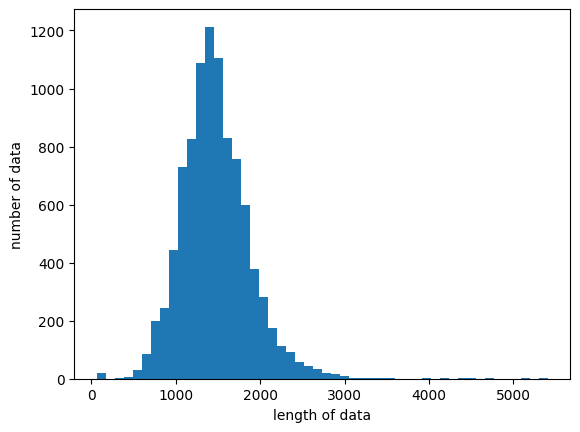

In [ ]:
#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in df['data']))
print('학습 문장의 평균 길이 :',sum(map(len, df['data']))/len(df['data']))

plt.hist([len(s) for s in df['data']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

학습 문장 최대 길이 : 3000
학습 문장의 평균 길이 : 1472.522555991933


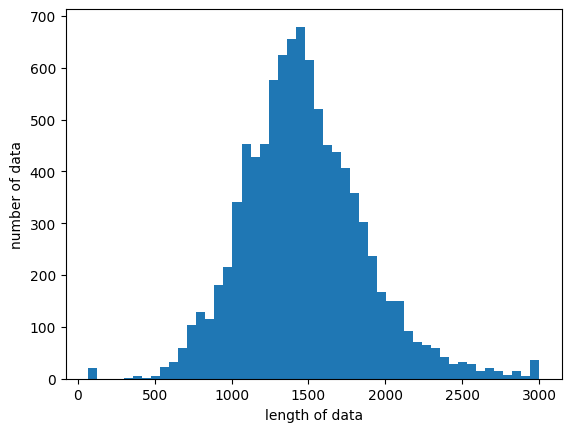

In [ ]:
# 문장 자르기 함수
max_length = 3000

def truncate_sentence(sentence, max_length):
    if len(sentence) > max_length:
        return sentence[:max_length]
    else:
        return sentence

# 'data' 열의 문장 자르기
df['data'] = df['data'].apply(lambda x: truncate_sentence(x, max_length))


#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in df['data']))
print('학습 문장의 평균 길이 :',sum(map(len, df['data']))/len(df['data']))

plt.hist([len(s) for s in df['data']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

#train_data = train_data.head(1000)
print(len(train_data))
print(len(test_data))
print(len(valid_data))

7630
943
848


Fine-tuning

In [ ]:
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokenized_train_sentences = tokenizer(
    list(train_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

tokenized_test_sentences = tokenizer(
    list(test_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', 'soft', 'city', 'sens', '##ing', 'turn', 'to', 'com', '##putation', '##al', 'human', '##ities', 'in', 'data', 'driven', 'urban', '##ism', '##data', 'driven', 'urban', '##ism', 'is', 'often', 'ent', '##ang', '##led', 'with', 'the', 'smart', 'city', 'and', 'practiced', 'in', 'way', 'that', 'prior', '##iti', '##zes', 'control', 'over', 'physical', 'objects', 'and', 'down', '##play', '##s', 'the', 'human', 'and', 'political', 'aspects', 'of', 'data', 'we', 'label', 'this', 'approach', 'hard', 'city', 'sens', '##ing', 'h', '##cs', 'and', 'we', 'argue', 'that', 'the', 'rise', 'of', 'the', 'digital', 'city', 'offers', 'the', 'em', '##pir', '##ical', 'foundation', 'for', 'more', 'human', '##istic', 'approaches', 'driven', 'by', 'the', 'amb', '##ition', 'to', 'un', '##tang', '##le', 'data', 'driven', 'urban', '##ism', 'from', 'h', '##cs', 'this', 'paper', 'reviews', 

In [ ]:
train_label = train_data['label'].values
test_label = test_data['label'].values

print(train_label[0])
print(test_label[0])

16
17


In [ ]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)
train_dataset[0]

<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'input_ids': tensor([   101,  44898,  11584,  21542,  10230,  18923,  10114,  10212,  99848,
          10415,  14179,  17285,  10106,  11165,  39803,  23351,  13397,  37273,
          39803,  23351,  13397,  10124,  12899,  61047,  11889,  16376,  10169,
          10105,  98507,  11584,  10111,  86925,  10106,  13170,  10189,  20972,
          13903,  19579,  12608,  10491,  22899,  32804,  10111,  12935,  31081,
          10107,  10105,  14179,  10111,  13736,  30686,  10108,  11165,  11951,
          16982,  10531,  23068,  19118,  11584,  21542,  10230,    176,  13331,
          10111,  11951,  93517,  10189,  10105,  28710,  10108,  10105,  16924,
          11584,  23818,  10105,  10266,  50193,  17616,  33572,  10142,  10798,
          14179,  29025,  63036,  39803,  10155,  10105,  10559,  25322,  10114,
          10119,  55085,  10284,  11165,  39803,  23351,  13397,  10188,    176,
          13331,  10531,  17895,  24860,  10551,  33256,  10108,  57125,  10189,
          10393

#epoch3

In [ ]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=30
)

num_labels = 20

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,1.723000
1000,1.052900
1500,0.757100
2000,0.633400
2500,0.385900


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=2778, training_loss=0.8547578184101717, metrics={'train_runtime': 886.3353, 'train_samples_per_second': 25.057, 'train_steps_per_second': 3.134, 'total_flos': 5844377813446656.0, 'train_loss': 0.8547578184101717, 'epoch': 3.0})

성능평가

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6228955984115601,
 'eval_accuracy': 0.8240437158469945,
 'eval_f1': 0.818557151232312,
 'eval_precision': 0.8204560203935042,
 'eval_recall': 0.8240437158469945,
 'eval_runtime': 8.177,
 'eval_samples_per_second': 111.9,
 'eval_steps_per_second': 1.834}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.6228955984115601,
 'eval_accuracy': 0.8240437158469945,
 'eval_f1': 0.8240437158469944,
 'eval_precision': 0.8240437158469945,
 'eval_recall': 0.8240437158469945,
 'eval_runtime': 8.1853,
 'eval_samples_per_second': 111.786,
 'eval_steps_per_second': 1.833}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6228955984115601,
 'eval_accuracy': 0.8240437158469945,
 'eval_f1': 0.6685744481359639,
 'eval_precision': 0.7406477028545235,
 'eval_recall': 0.6475672597307877,
 'eval_runtime': 8.1568,
 'eval_samples_per_second': 112.177,
 'eval_steps_per_second': 1.839}

Prediction

In [ ]:
from transformers import pipeline

def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to('cuda')

    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result



plan_sample = "currently population and development growth in south east queensland is managed under the south east queensland regional plan 2005 2026 which promotes both urban consolidation of the city centre and decentralisation into new urban centres in and outside brisbane the expectation is that councils will prepare strategic development plans for each identified growth area however in the brisbane city centre the council has now identified some 30 separate growth areas all being planned independently some under council and others under state government jurisdiction some well advanced and others yet to commence planning this fragmented approach is unlikely to generate smart city this report calls for the identification of an holistic vision and structure for the city centre aimed at generating public awareness and confidence that brisbane is evolving as smart city dramatically and innovatively enhancing connectivity throughout the city centre collocating residential and commercial growth with knowledge precincts creating knowledge corridor through the city centre manifesting connectivity in ways which will impart the city with powerful identity integrating the knowledge economy with subtropical lifestyle "
#원래 토픽: 2(technology, continue, exist, priority)
#(epoch1)결과 토픽: 11(mobility  transport  area  plan  sustainable  development  people  growth  activity  change)

print(sentences_predict(plan_sample))

11


#epoch 7



In [ ]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=7,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=30
)

num_labels = 20

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,1.752500
1000,1.198000
1500,0.903600
2000,0.758000
2500,0.614100
3000,0.516100
3500,0.417600
4000,0.335900
4500,0.273800
5000,0.175900


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=6482, training_loss=0.5573925187800336, metrics={'train_runtime': 2018.3636, 'train_samples_per_second': 25.675, 'train_steps_per_second': 3.212, 'total_flos': 1.3636881564708864e+16, 'train_loss': 0.5573925187800336, 'epoch': 7.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 1.1129666566848755,
 'eval_accuracy': 0.8306010928961749,
 'eval_f1': 0.8296582674176716,
 'eval_precision': 0.8334984954660041,
 'eval_recall': 0.8306010928961749,
 'eval_runtime': 8.2579,
 'eval_samples_per_second': 110.803,
 'eval_steps_per_second': 1.816}

#epoch 5

In [ ]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=30
)

num_labels = 20

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,1.752500
1000,1.162300
1500,0.888100
2000,0.747700
2500,0.586900
3000,0.487300
3500,0.368500
4000,0.234100
4500,0.178900


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=4630, training_loss=0.6973447087001594, metrics={'train_runtime': 1577.5801, 'train_samples_per_second': 23.463, 'train_steps_per_second': 2.935, 'total_flos': 9740629689077760.0, 'train_loss': 0.6973447087001594, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.8397821187973022,
 'eval_accuracy': 0.8316939890710382,
 'eval_f1': 0.8301169308825808,
 'eval_precision': 0.8350178647468441,
 'eval_recall': 0.8316939890710382,
 'eval_runtime': 8.2111,
 'eval_samples_per_second': 111.435,
 'eval_steps_per_second': 1.827}

#epoch 6

In [ ]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=6,             # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=30
)
num_labels = 20

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,1.485600
1000,0.770500
1500,0.503800
2000,0.320500
2500,0.170300
3000,0.084400


<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=3339, training_loss=0.5044479775692967, metrics={'train_runtime': 1747.6077, 'train_samples_per_second': 30.562, 'train_steps_per_second': 1.911, 'total_flos': 1.405503260012544e+16, 'train_loss': 0.5044479775692967, 'epoch': 7.0})

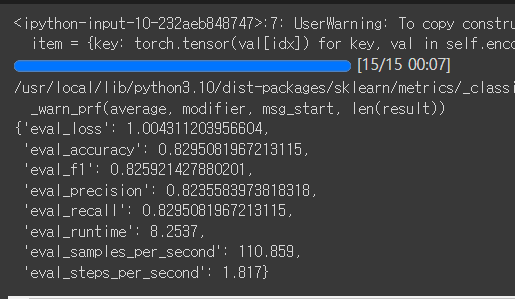

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0547813177108765,
 'eval_accuracy': 0.809119830328738,
 'eval_f1': 0.8072536683335062,
 'eval_precision': 0.8118459815092365,
 'eval_recall': 0.809119830328738,
 'eval_runtime': 8.663,
 'eval_samples_per_second': 108.854,
 'eval_steps_per_second': 1.732}

저장한 모델 로드

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# 모델 경로를 지정합니다.
model_path = './results_1102_6epoch/checkpoint-2500'  # 모델이 저장된 디렉토리

# 모델 및 토크나이저를 로드합니다.
model = BertForSequenceClassification.from_pretrained(model_path)
#tokenizer = BertTokenizer.from_pretrained(model_path)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-12-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.7949029803276062,
 'eval_accuracy': 0.8218451749734889,
 'eval_f1': 0.8181740231088809,
 'eval_precision': 0.8223763298587099,
 'eval_recall': 0.8218451749734889,
 'eval_runtime': 8.6201,
 'eval_samples_per_second': 109.395,
 'eval_steps_per_second': 1.74}

#inference_patent_topic

In [ ]:
path = './data/'
base_df = pd.read_csv(os.path.join(path, 'patent_abs_3870_raw.csv'), encoding='utf-8',error_bad_lines=False)

# NaN 값을 제거하기 위해 필요한 경우 아래 코드를 추가로 실행
base_df = base_df.dropna()

# 텍스트 전처리
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'\W', ' ', text)
    # 한 글자짜리 단어 제거
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # 여러 개의 공백을 하나로 줄임
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # 'b'로 시작하는 문자열 제거
    #text = re.sub(r'^b\s+', '', text)
    return text

base_df['text'] = base_df['text'].apply(preprocess_text)

# 중복 특허 삭제
base_df = base_df.sort_values(by='id', ascending=False).drop_duplicates()

# 인덱스를 리셋
base_df = base_df.reset_index(drop=True)
base_df = base_df.iloc[:, 1:]
corpus = base_df.dropna()
print(corpus.shape)
corpus.tail(3)

<ipython-input-27-6313d1b50067>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  base_df = pd.read_csv(os.path.join(path, 'patent_abs_3870_raw.csv'), encoding='utf-8',error_bad_lines=False)


(3846, 9)


,id_org,id,title,priority date,filing/creation date,publication date,grant date,abs,text
3843,AU-2018101266-A4,AU2018101266A4,Vertical Wind Turbine with integrated Solar Pa...,06/09/2018,06/09/2018,08/11/2018,08/11/2018,Abstract The invention relates to a vertical w...,vertical wind turbine with integrated solar pa...
3844,AU-2017389088-B2,AU2017389088B2,Beam forming auxiliary unit for antenna and te...,30/12/2016,24/11/2017,17/02/2022,17/02/2022,The present disclosure relates to a communicat...,beam forming auxiliary unit for antenna and te...
3845,AU-2017304556-B2,AU2017304556B2,Method and apparatus for reporting channel sta...,29/07/2016,28/07/2017,30/09/2021,30/09/2021,Disclosed are a communication method for mergi...,method and apparatus for reporting channel sta...


In [ ]:
from transformers import pipeline

def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to('cuda')

    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result



plan_sample = "currently population and development growth in south east queensland is managed under the south east queensland regional plan 2005 2026 which promotes both urban consolidation of the city centre and decentralisation into new urban centres in and outside brisbane the expectation is that councils will prepare strategic development plans for each identified growth area however in the brisbane city centre the council has now identified some 30 separate growth areas all being planned independently some under council and others under state government jurisdiction some well advanced and others yet to commence planning this fragmented approach is unlikely to generate smart city this report calls for the identification of an holistic vision and structure for the city centre aimed at generating public awareness and confidence that brisbane is evolving as smart city dramatically and innovatively enhancing connectivity throughout the city centre collocating residential and commercial growth with knowledge precincts creating knowledge corridor through the city centre manifesting connectivity in ways which will impart the city with powerful identity integrating the knowledge economy with subtropical lifestyle "
#원래 토픽: 2(technology, continue, exist, priority)
#(epoch1)결과 토픽: 11(mobility  transport  area  plan  sustainable  development  people  growth  activity  change)

print(sentences_predict(plan_sample))

16


In [ ]:
corpus["topic_B"] = corpus["text"].apply(lambda x: sentences_predict(x))
corpus

,id_org,id,title,priority date,filing/creation date,publication date,grant date,abs,text,topic_B
0,US-9996309-B2,US9996309B2,Method and apparatus for providing search info...,02/12/2015,01/12/2016,12/06/2018,12/06/2018,The present disclosure relates to technologies...,method and apparatus for providing search info...,14
1,US-9980127-B2,US9980127B2,Method and apparatus for performing pairing pr...,07/10/2014,05/10/2015,22/05/2018,22/05/2018,The present disclosure relates to a sensor net...,method and apparatus for performing pairing pr...,14
2,US-9961479-B2,US9961479B2,Method and apparatus for registering devices i...,20/06/2014,22/06/2015,01/05/2018,01/05/2018,A method and apparatus for a master gateway to...,method and apparatus for registering devices i...,14
3,US-9955550-B2,US9955550B2,Electronic device and method for setup of ligh...,05/06/2014,04/06/2015,24/04/2018,24/04/2018,The present disclosure relates to a sensor net...,electronic device and method for setup of ligh...,14
4,US-9955284-B2,US9955284B2,Apparatus and method for operating ad-hoc mode...,12/12/2014,11/12/2015,24/04/2018,24/04/2018,The present disclosure relates to a sensor net...,apparatus and method for operating ad hoc mode...,14
...,...,...,...,...,...,...,...,...,...,...
3841,AU-2019100273-A4,AU2019100273A4,BinWin is a modern-day waste collection techno...,15/03/2019,15/03/2019,02/05/2019,02/05/2019,Abstract BINWIN TABLEOFCONTENTS BINWIN 1. Intr...,binwin is modern day waste collection technolo...,6
3842,AU-2018286373-B2,AU2018286373B2,"Method, apparatus, and system for RACH resourc...",15/06/2017,14/06/2018,21/07/2022,21/07/2022,A communication method and system for convergi...,method apparatus and system for rach resource ...,14
3843,AU-2018101266-A4,AU2018101266A4,Vertical Wind Turbine with integrated Solar Pa...,06/09/2018,06/09/2018,08/11/2018,08/11/2018,Abstract The invention relates to a vertical w...,vertical wind turbine with integrated solar pa...,5
3844,AU-2017389088-B2,AU2017389088B2,Beam forming auxiliary unit for antenna and te...,30/12/2016,24/11/2017,17/02/2022,17/02/2022,The present disclosure relates to a communicat...,beam forming auxiliary unit for antenna and te...,14


In [ ]:
corpus_id_topic = corpus[["id", "topic_B"]]
corpus_id_topic.to_csv("patent_topicB_3.csv")

#inference_plans_topic

In [ ]:
path = './data/'
base_df = pd.read_csv(os.path.join(path, 'masterplan_51.csv'), encoding='utf-8',error_bad_lines=False)

# NaN 값을 제거하기 위해 필요한 경우 아래 코드를 추가로 실행
base_df = base_df.dropna()

# 텍스트 전처리
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'\W', ' ', text)
    # 한 글자짜리 단어 제거
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # 여러 개의 공백을 하나로 줄임
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # 'b'로 시작하는 문자열 제거
    #text = re.sub(r'^b\s+', '', text)
    return text

base_df['text'] = base_df['text'].apply(preprocess_text)

# 인덱스를 리셋
base_df = base_df.reset_index(drop=True)
base_df = base_df.iloc[:, 1:]
corpus = base_df.dropna()
corpus['plan_id'] = range(1, 52)
print(corpus.shape)
corpus.tail(3)

<ipython-input-31-90a142dab33c>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  base_df = pd.read_csv(os.path.join(path, 'masterplan_51.csv'), encoding='utf-8',error_bad_lines=False)


(51, 4)


,city,country,text,plan_id
48,Stravanger,Norway,the roadmap for the smart city stavanger point...,49
49,Aarhus,Denmark,for most people the idea of city lab is far fr...,50
50,Tampere,Finland,city of tampere in finland aims for innovative...,51


In [ ]:
corpus["topic_B"] = corpus["text"].apply(lambda x: sentences_predict(x))
corpus

,city,country,text,plan_id,topic_B
0,Brisbane,Australia,currently population and development growth in...,1,16
1,Busselton,Australia,the city of busselton smart city strategy 2020...,2,16
2,Charles sturt,Australia,smart cities attract knowledge creativity and ...,3,16
3,Glen eira,Australia,glen eira city council is getting ready for th...,4,16
4,Hobart,Australia,towards australia most economically socially a...,5,10
5,Norwood,Australia,our city is well regarded as progressive susta...,6,16
6,Parramatta,Australia,parramatta is on the move widespread redevelop...,7,16
7,Stonnington,Australia,the city of stonnington cos is ready to begin ...,8,16
8,Sydney,Australia,the city of sydney is experiencing rapid chang...,9,16
9,Wanneroo,Australia,the city of wanneroo the city is embracing thi...,10,16


In [ ]:
corpus_id_topic = corpus[["plan_id", "topic_B"]]
corpus_id_topic.to_csv("plan_topicB_3.csv")

#epoch15

In [ ]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=15,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=30
)

num_labels = 20

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,1.756200
1000,1.128700
1500,0.850700
2000,0.742900
2500,0.571500
3000,0.502000
3500,0.409700
4000,0.333000
4500,0.303100
5000,0.223600


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=13890, training_loss=0.28472288240892496, metrics={'train_runtime': 4247.7294, 'train_samples_per_second': 26.142, 'train_steps_per_second': 3.27, 'total_flos': 2.922188906723328e+16, 'train_loss': 0.28472288240892496, 'epoch': 15.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://aimb.tistory.com/152)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.9268256425857544,
 'eval_accuracy': 0.8010928961748633,
 'eval_f1': 0.800103936653363,
 'eval_precision': 0.8042733649175097,
 'eval_recall': 0.8010928961748633,
 'eval_runtime': 8.2414,
 'eval_samples_per_second': 111.025,
 'eval_steps_per_second': 1.82}

#epoch30

In [ ]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=30
)

num_labels = 20

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,1.738000
1000,1.098600
1500,0.856300
2000,0.770700
2500,0.631800
3000,0.537800
3500,0.468500
4000,0.402900
4500,0.359500
5000,0.273800


<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=27780, training_loss=0.1769490831981489, metrics={'train_runtime': 8704.8798, 'train_samples_per_second': 25.513, 'train_steps_per_second': 3.191, 'total_flos': 5.844377813446656e+16, 'train_loss': 0.1769490831981489, 'epoch': 30.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

"""
모든 라벨이 유사한 중요도를 가진다면 macro average 값을 참고하고,
샘플이 많은 라벨에 중요도를 두고 싶다면 weighted average 값
라벨에 상관없이 전체적인 성능을 평가하고 싶을 때는 micro average, 즉 accuracy 를 활용
"""


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #(None, 'micro', 'macro', 'weighted', 'samples')’(https://data-minggeul.tistory.com/11)
    #Samplewise metrics are not available outside of multilabel classification.
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-10-232aeb848747>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 2.3432350158691406,
 'eval_accuracy': 0.7945355191256831,
 'eval_f1': 0.793390650017526,
 'eval_precision': 0.7956034012509967,
 'eval_recall': 0.7945355191256831,
 'eval_runtime': 8.1958,
 'eval_samples_per_second': 111.642,
 'eval_steps_per_second': 1.83}

In [ ]:
from transformers import pipeline

def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to('cuda')

    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result



plan_sample = "currently population and development growth in south east queensland is managed under the south east queensland regional plan 2005 2026 which promotes both urban consolidation of the city centre and decentralisation into new urban centres in and outside brisbane the expectation is that councils will prepare strategic development plans for each identified growth area however in the brisbane city centre the council has now identified some 30 separate growth areas all being planned independently some under council and others under state government jurisdiction some well advanced and others yet to commence planning this fragmented approach is unlikely to generate smart city this report calls for the identification of an holistic vision and structure for the city centre aimed at generating public awareness and confidence that brisbane is evolving as smart city dramatically and innovatively enhancing connectivity throughout the city centre collocating residential and commercial growth with knowledge precincts creating knowledge corridor through the city centre manifesting connectivity in ways which will impart the city with powerful identity integrating the knowledge economy with subtropical lifestyle "
#원래 토픽: 2(technology, continue, exist, priority)
#(epoch1)결과 토픽: 11(mobility  transport  area  plan  sustainable  development  people  growth  activity  change)

print(sentences_predict(plan_sample))

11


#아이펠실험

In [ ]:
path = './data/'
df = pd.read_csv(os.path.join(path, 'bert_train.csv'), encoding='utf-8',error_bad_lines=False)
#data shuffle
df = df.sample(frac=1)

def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

def check_class(it):
    if '협박' in it:
        return 0
    elif '갈취' in it:
        return 1
    elif '직장 내 괴롭힘' in it:
        return 2
    elif '기타 괴롭힘' in it:
        return 3
    else:
        return 4

df['data'] = df['conversation'].apply(lambda it : preprocess_sentence(it))
df['label'] = df['class'].apply(lambda it: check_class(it))

df = df[['data', 'label']]
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)
print(len(train_data))
print(len(test_data))
print(len(valid_data))

<ipython-input-18-0aaef1e8dba2>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(os.path.join(path, 'bert_train.csv'), encoding='utf-8',error_bad_lines=False)


3199
395
356


In [ ]:
tokenized_train_sentences = tokenizer(
    list(train_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

tokenized_test_sentences = tokenizer(
    list(test_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '부', '##장', '##님', '저', '휴', '##가', '갈', '##게', '##요', '휴', '##가', '?', '이', '##건', '아', '##니', '##지', '세', '##은', '##씨', '.', '그', '##치', '먼저', '기', '##다', '##리는', '사', '##람', '##도', '있', '##데', '.', '먼저', '쓰', '##는', '사람이', '임', '##자', '아닌', '##가', '##요', '?', '신', '##입', '##이', '왜', '##이', '##리', '싸', '##가지', '##가', '없', '##어', '?', '그', '##러', '##게', '말', '##이', '##에', '##요', '뭐', '?', '싸', '##가지', '?', '너', '##네', '나', '괴', '##롭', '##히', '##는', '거', '##니', '?', '이', '##제', '알', '##았', '##니', '?', '너', '##도', '참', '둔', '##하다', '[UNK]', '울', '##면서', '나', '##간', '##다', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [ ]:
train_label = train_data['label'].values
test_label = test_data['label'].values

print(train_label)
print(test_label)

[2 3 2 ... 1 2 0]
[1 2 3 3 1 2 2 3 1 2 0 1 0 1 0 0 0 1 0 1 0 2 3 2 2 2 3 2 1 2 1 2 3 3 0 2 2
 0 3 0 2 1 1 2 1 0 2 3 3 0 0 2 2 1 2 3 3 1 0 2 2 1 2 3 2 1 3 3 3 3 2 0 2 3
 0 2 1 2 1 0 1 1 0 0 1 0 3 2 1 3 3 0 2 2 1 2 1 2 1 2 0 2 3 0 0 3 1 3 2 2 3
 2 2 0 1 0 3 0 2 3 2 3 0 1 2 2 2 2 3 3 0 0 3 3 0 1 1 3 2 1 2 1 1 3 1 0 2 3
 2 3 1 0 1 0 1 1 1 3 3 1 0 1 0 3 1 1 0 2 0 1 1 1 3 0 2 2 1 2 2 3 0 0 1 3 0
 3 2 0 1 3 0 0 3 0 3 1 3 3 3 3 1 2 1 1 1 1 3 3 3 1 0 0 1 3 2 0 3 0 0 3 2 3
 2 0 0 3 2 2 1 2 2 2 1 3 3 2 1 3 3 3 1 2 0 0 3 2 3 3 3 0 0 3 2 3 1 0 0 2 3
 1 3 1 2 0 2 1 3 3 3 3 3 2 0 3 1 0 3 0 2 0 1 0 1 2 2 3 3 3 0 0 3 2 0 1 0 2
 1 3 3 0 2 3 0 1 3 0 1 0 1 0 0 1 1 3 1 0 0 1 3 1 3 1 3 1 3 0 1 0 3 3 3 0 0
 3 3 1 3 2 1 2 2 0 0 1 3 2 1 1 2 2 3 3 3 3 2 2 1 0 2 2 2 2 2 3 0 2 2 3 3 3
 2 1 3 2 3 2 2 3 1 2 3 1 3 0 2 0 0 0 0 1 3 2 1 3 3]


In [ ]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

num_labels = 4

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: ignored